[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent_exercise.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent Exercise: Building a ReAct Agent

## Learning Objectives

By the end of this exercise, you will be able to:
1. Understand the ReAct (Reason + Act) agent architecture
2. Build a tool-calling agent with multiple tools
3. Create loops in LangGraph for iterative agent behavior
4. Debug and trace agent execution using LangSmith

## Background: From Router to Agent

In the previous lesson, we built a router that could decide whether to call a tool or end. Now we'll extend this into a full agent that can:
- **Act**: Call specific tools based on user input
- **Observe**: Receive tool outputs
- **Reason**: Decide what to do next (call another tool or respond)

This creates a loop where the agent can chain multiple tool calls together to solve complex problems.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:
# Optional: Set up LangSmith tracing
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy-exercises"

## Exercise 1: Define Your Tools

**Task**: Create a set of mathematical tools for your agent. Start with the basic ones provided, then add your own.

**Instructions**:
1. Complete the `subtract` function below
2. Add a `power` function that raises a number to a power
3. Add a `square_root` function that calculates the square root
4. Make sure all functions have proper docstrings with type hints

In [6]:
from langchain_openai import ChatOpenAI
import math

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# TODO: Complete this function
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

# TODO: Add your power function here
def power(a: int, b: int) -> float:
    """Raise a to the power of b.

    Args:
        a: base number
        b: exponent
    """
    return a**b

# TODO: Add your square_root function here
def square_root(a: float) -> float:
    """Calculate the square root of a.

    Args:
        a: number to calculate square root of
    """
    # YOUR CODE HERE
    return a**(0.5)

# Update this list with your new tools
tools = [add, multiply, divide, subtract, power, square_root]  # TODO: Add your new tools here


llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

## Exercise 2: Create the Assistant Node

**Task**: Define your assistant node with an appropriate system message.

**Instructions**:
1. Complete the system message to give your agent clear instructions
2. Think about what personality or behavior you want your agent to have
3. Consider what constraints or guidelines you want to provide

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# TODO: Complete this system message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with helping the user answer questions")

def assistant(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg]+state['messages'])]}

assistant({'messages':[HumanMessage(content='Hello.')]})

{'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 215, 'total_tokens': 225, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAgUd2QQXvUmmzPTg5RRwOniMxFs5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--686c6c95-e6a6-4cc5-959a-bdd07cdd9ba6-0', usage_metadata={'input_tokens': 215, 'output_tokens': 10, 'total_tokens': 225, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## Exercise 3: Build Your Agent Graph

**Task**: Create the agent graph with proper connections.

**Instructions**:
1. Add the assistant and tools nodes
2. Create the correct edges:
   - From START to assistant
   - Conditional edge from assistant (using tools_condition)
   - Edge from tools back to assistant (this creates the loop!)
3. Compile and visualize your graph

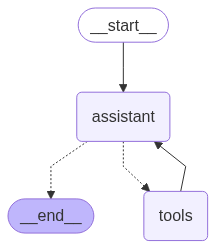

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# TODO: Create your graph
builder = StateGraph(MessagesState)

# TODO: Add nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# TODO: Add edges
builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', tools_condition) # will either go to tool or end
builder.add_edge('tools', 'assistant')
# builder.add_conditional_edges(...)

# configure memory

memory = MemorySaver()
# TODO: Compile your graph
agent_graph = builder.compile(checkpointer=memory)

# Visualize the graph
display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))

## Exercise 4: Test Your Agent

**Task**: Test your agent with increasingly complex mathematical problems.

**Instructions**:
1. Start with simple problems and work your way up
2. Test each of your tools
3. Try problems that require multiple tool calls
4. Observe how the agent chains operations together

In [22]:
# Test 1: Simple addition
print("=== Test 1: Simple Addition ===")
messages = [HumanMessage(content="What is 12/0?")]
# TODO: Invoke your agent and print the results
results = agent_graph.invoke({'messages':messages})
print(results['messages'][-1].content)

# Test 2: Chain operations
print("\n=== Test 2: Chain Operations ===")
messages = [HumanMessage(content="Calculate (8 + 12) * 3, then divide by 4")]
results = agent_graph.invoke({'messages':messages})
print(results['messages'][-1].content)

# Test 3: Complex calculation
print("\n=== Test 3: Complex Calculation ===")
messages = [HumanMessage(content="What is the square root of -1, then raise that to the power of 3?")]
results = agent_graph.invoke({'messages':messages})
print(results['messages'][-1].content)

=== Test 1: Simple Addition ===
Dividing by zero is undefined in mathematics. Therefore, 12 divided by 0 does not have a defined value.

=== Test 2: Chain Operations ===
The result of \((8 + 12) * 3\) divided by 4 is \(15.0\).

=== Test 3: Complex Calculation ===
The square root of \(-1\) in the context of complex numbers is represented as \(i\), where \(i\) is the imaginary unit. 

Raising \(i\) to the power of 3 gives us:

\[i^3 = i \cdot i \cdot i = i^2 \cdot i = (-1) \cdot i = -i\]

So, the result of raising the square root of \(-1\) to the power of 3 is \(-i\).


## with memory from last thread

In [ ]:
#test with memory
config = {'configurable': {'thread_id': '4'}}

print("=== Test 1: Simple Addition ===")
messages = [HumanMessage(content="What is 3 * 4?")]
# it will restore the last checkpoint from the thread
results = agent_graph.invoke({'messages':messages}, config=config)
for m in results['messages']:
    m.pretty_print()

# Test 2: Chain operations
print("\n=== Test 2: Chain Operations ===")
messages = [HumanMessage(content="Multiply that by 10")]
results = agent_graph.invoke({'messages':messages}, config=config)

for m in results['messages']:
    m.pretty_print()


=== Test 1: Simple Addition ===
================================ Human Message =================================

What is 3 * 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1dbHuX7IVkTVeppC7FFGJsZg)
 Call ID: call_1dbHuX7IVkTVeppC7FFGJsZg
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

\(3 \times 4\) equals 12.

=== Test 2: Chain Operations ===
================================ Human Message =================================

What is 3 * 4?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_1dbHuX7IVkTVeppC7FFGJsZg)
 Call ID: call_1dbHuX7IVkTVeppC7FFGJsZg
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
============================

## Exercise 5: Add Error Handling

**Task**: Make your agent more robust by handling potential errors.

**Instructions**:
1. Modify your `divide` function to handle division by zero
2. Modify your `square_root` function to handle negative numbers
3. Test your agent with problematic inputs

In [ ]:
# TODO: Create improved versions of your tools with error handling

def safe_divide(a: int, b: int) -> float:
    """Safely divide a by b, handling division by zero.

    Args:
        a: numerator
        b: denominator
    """
    # YOUR CODE HERE
    pass

def safe_square_root(a: float) -> float:
    """Safely calculate square root, handling negative numbers.

    Args:
        a: number to calculate square root of
    """
    # YOUR CODE HERE
    pass

# Test error cases
print("=== Testing Error Handling ===")
# TODO: Test with division by zero
# TODO: Test with square root of negative number

## Exercise 6: Extend with New Tool Categories

**Task**: Add non-mathematical tools to demonstrate the agent's versatility.

**Instructions**:
1. Add string manipulation tools (e.g., `reverse_string`, `count_words`)
2. Add utility tools (e.g., `get_current_time`, `generate_random_number`)
3. Update your system message to reflect the new capabilities
4. Test with mixed requests that combine math and other operations

In [ ]:
import random
from datetime import datetime

# TODO: Add string manipulation tools
def reverse_string(text: str) -> str:
    """Reverse the given string.

    Args:
        text: string to reverse
    """
    # YOUR CODE HERE
    pass

def count_words(text: str) -> int:
    """Count the number of words in the text.

    Args:
        text: string to count words in
    """
    # YOUR CODE HERE
    pass

# TODO: Add utility tools
def get_current_time() -> str:
    """Get the current date and time."""
    # YOUR CODE HERE
    pass

def generate_random_number(min_val: int, max_val: int) -> int:
    """Generate a random number between min_val and max_val (inclusive).

    Args:
        min_val: minimum value
        max_val: maximum value
    """
    # YOUR CODE HERE
    pass

# TODO: Update your tools list and rebuild your agent
# extended_tools = [...]
# llm_with_extended_tools = llm.bind_tools(extended_tools, parallel_tool_calls=False)

# TODO: Create a new assistant with updated system message
# def extended_assistant(state: MessagesState):
#     updated_sys_msg = SystemMessage(content="...")
#     return {"messages": [llm_with_extended_tools.invoke([updated_sys_msg] + state["messages"])]}

## Exercise 7: Test Mixed Operations

**Task**: Create test cases that require your agent to use different types of tools in sequence.

**Instructions**:
1. Design complex workflows that mix mathematical and non-mathematical operations
2. Test the agent's ability to maintain context across different tool types
3. Observe how the agent decides which tools to use and in what order

In [ ]:
# TODO: Create and test mixed operation scenarios

# Example ideas:
# - "Generate a random number between 1 and 10, then calculate its square"
# - "Count the words in 'Hello world from LangChain', then multiply by 5"
# - "What's the current time, and also what's 25 + 17?"

test_cases = [
    # TODO: Add your test cases here
]

# TODO: Run each test case and analyze the results

## Reflection Questions

After completing the exercises, consider these questions:

1. **Tool Selection**: How does the agent decide which tools to use? What happens when multiple tools could solve the same problem?

2. **Error Recovery**: How well does your agent handle errors? What improvements could you make to error handling?

3. **Loop Behavior**: When does the agent decide to stop calling tools? How could you influence this behavior?

4. **System Message Impact**: How does changing the system message affect agent behavior? Try different personalities or constraints.

5. **Tool Design**: What makes a good tool for an agent? How should you design tools for optimal agent performance?

## Challenge: Build a Specialized Agent

**Task**: Create an agent specialized for a specific domain (e.g., data analysis, text processing, or unit conversions).

**Requirements**:
1. Choose a domain and create 5-7 specialized tools
2. Write a comprehensive system message for your domain
3. Test with domain-specific complex scenarios
4. Document your agent's capabilities and limitations

## Next Steps

Congratulations! You've built a fully functional ReAct agent. In the next modules, you'll learn about:
- State management and memory
- Human-in-the-loop workflows
- Advanced agent patterns
- Multi-agent systems

## Resources

- [ReAct Paper](https://react-lm.github.io/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Tool Calling Guide](https://python.langchain.com/docs/how_to/tool_calling/)

---
*This exercise notebook is part of LangChain Academy Module 1. For more resources and the complete course, visit [LangChain Academy](https://academy.langchain.com/).*